Loaded 140 full scenes.
Start Training PointPillars...
Epoch 001 | LR: 0.00100 | mAP: 0.0000
Epoch 002 | LR: 0.00100 | ...
Epoch 003 | LR: 0.00100 | mAP: 0.0323
Epoch 004 | LR: 0.00100 | ...
Epoch 005 | LR: 0.00100 | mAP: 0.2097
Epoch 006 | LR: 0.00100 | ...
Epoch 007 | LR: 0.00100 | mAP: 0.2903
Epoch 008 | LR: 0.00100 | ...
Epoch 009 | LR: 0.00100 | mAP: 0.2903
Epoch 010 | LR: 0.00100 | ...
Epoch 011 | LR: 0.00100 | mAP: 0.4355
Epoch 012 | LR: 0.00100 | ...
Epoch 013 | LR: 0.00100 | mAP: 0.4194
Epoch 014 | LR: 0.00100 | ...
Epoch 015 | LR: 0.00100 | mAP: 0.4194
Epoch 016 | LR: 0.00100 | ...
Epoch 017 | LR: 0.00100 | mAP: 0.5000
Epoch 018 | LR: 0.00100 | ...
Epoch 019 | LR: 0.00100 | mAP: 0.5806
Epoch 020 | LR: 0.00100 | ...
Epoch 021 | LR: 0.00100 | mAP: 0.4839
Epoch 022 | LR: 0.00100 | ...
Epoch 023 | LR: 0.00100 | mAP: 0.5323
Epoch 024 | LR: 0.00100 | ...
Epoch 025 | LR: 0.00100 | mAP: 0.5484
Epoch 026 | LR: 0.00100 | ...
Epoch 027 | LR: 0.00100 | mAP: 0.5323
Epoch 028 | LR: 0.00100

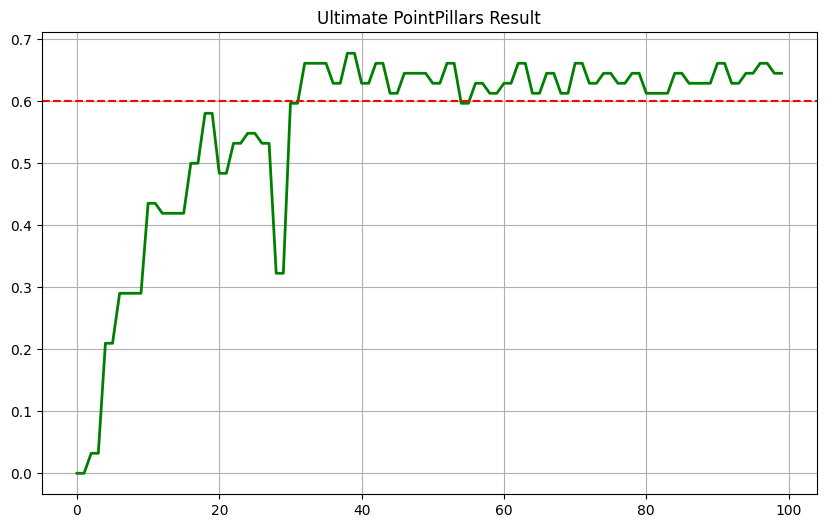

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

CONFIG = {
    'voxel_size': [0.1, 0.1],   
    'pc_range': [-3, -3, -2, 3, 3, 2],
    'out_features': 64,
}

# PillarLayer 
class PillarLayer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.voxel_size = cfg['voxel_size']
        self.pc_range = cfg['pc_range']
        self.nx = int((self.pc_range[3] - self.pc_range[0]) / self.voxel_size[0])
        self.ny = int((self.pc_range[4] - self.pc_range[1]) / self.voxel_size[1])
        
        self.pfn = nn.Sequential(
            nn.Linear(9, cfg['out_features']),
            nn.GroupNorm(8, cfg['out_features']), 
            nn.ReLU(),
        )

    def forward(self, points_list):
        batch_canvases = []
        for b, pts in enumerate(points_list):
            if len(pts) == 0:
                batch_canvases.append(torch.zeros(64, self.ny, self.nx))
                continue
            
            mask = (pts[:,0] > self.pc_range[0]) & (pts[:,0] < self.pc_range[3]) & \
                   (pts[:,1] > self.pc_range[1]) & (pts[:,1] < self.pc_range[4])
            pts = pts[mask]
            
            if len(pts) == 0:
                batch_canvases.append(torch.zeros(64, self.ny, self.nx))
                continue

            coords_x = ((pts[:,0] - self.pc_range[0]) / self.voxel_size[0]).long()
            coords_y = ((pts[:,1] - self.pc_range[1]) / self.voxel_size[1]).long()
            coords_x = torch.clamp(coords_x, 0, self.nx - 1)
            coords_y = torch.clamp(coords_y, 0, self.ny - 1)
            indices = coords_y * self.nx + coords_x
            
            x_center = (coords_x.float() * self.voxel_size[0] + self.pc_range[0] + self.voxel_size[0]/2)
            y_center = (coords_y.float() * self.voxel_size[1] + self.pc_range[1] + self.voxel_size[1]/2)
            
            features = torch.stack([
                pts[:,0], pts[:,1], pts[:,2],
                torch.norm(pts[:,:2], dim=1),
                pts[:,0] - x_center,
                pts[:,1] - y_center,
                pts[:,2],
                pts[:,0], pts[:,1]
            ], dim=1)
            
            point_embed = self.pfn(features)
            
            canvas_flat = torch.zeros(self.ny * self.nx, 64)
            canvas_flat.index_add_(0, indices, point_embed)
            batch_canvases.append(canvas_flat.transpose(0, 1).view(64, self.ny, self.nx))
            
        return torch.stack(batch_canvases)

class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1), nn.GroupNorm(8, 64), nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1, stride=2), nn.GroupNorm(8, 128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1, stride=2), nn.GroupNorm(8, 128), nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=4)
        )
    def forward(self, x):
        return self.blocks(x)

class Head(nn.Module):
    def __init__(self):
        super().__init__()
        self.heatmap_head = nn.Conv2d(128, 1, 1) 
        self.reg_head = nn.Conv2d(128, 6, 1)
        
    def forward(self, x):
        hm = torch.sigmoid(self.heatmap_head(x))
        reg = self.reg_head(x)
        return hm, reg

class CustomPointPillars(nn.Module):
    def __init__(self):
        super().__init__()
        self.pillar_layer = PillarLayer(CONFIG)
        self.backbone = Backbone()
        self.head = Head()
        
    def forward(self, points):
        bev_map = self.pillar_layer(points)
        features = self.backbone(bev_map)
        hm, reg = self.head(features)
        return hm, reg

def compute_loss(pred_hm, pred_reg, gt_boxes, cfg):
    batch_size = pred_hm.shape[0]
    ny, nx = pred_hm.shape[2], pred_hm.shape[3]
    target_hm = torch.zeros_like(pred_hm)
    target_reg_mask = torch.zeros_like(pred_hm)
    target_reg = torch.zeros_like(pred_reg)
    
    for b in range(batch_size):
        boxes = gt_boxes[b]
        for box in boxes:
            cx, cy = box[0], box[1]
            ix = int((cx - cfg['pc_range'][0]) / cfg['voxel_size'][0])
            iy = int((cy - cfg['pc_range'][1]) / cfg['voxel_size'][1])
            if 0 <= ix < nx and 0 <= iy < ny:
                target_hm[b, 0, max(0,iy-1):min(ny,iy+2), max(0,ix-1):min(nx,ix+2)] = 0.5
                target_hm[b, 0, iy, ix] = 1.0
                target_reg_mask[b, 0, iy, ix] = 1.0
                target_reg[b, :, iy, ix] = torch.tensor([cx, cy, box[2], box[3], box[4], box[5]])

    pos_loss = -torch.log(pred_hm + 1e-4) * torch.pow(1 - pred_hm, 2) * target_hm
    neg_loss = -torch.log(1 - pred_hm + 1e-4) * torch.pow(pred_hm, 2) * (1 - target_hm)
    loss_reg = (torch.abs(pred_reg - target_reg) * target_reg_mask).sum() * 10.0
    return (pos_loss + neg_loss).sum() + loss_reg

def decode_predictions(hm, reg, cfg, score_thresh=0.4):
    batch_size = hm.shape[0]
    pred_boxes = []
    for b in range(batch_size):
        scores = hm[b, 0]
        ys, xs = torch.where(scores > score_thresh)
        boxes_b = []
        if len(xs) > 0:
            for i in range(len(xs)):
                ix, iy = xs[i], ys[i]
                r = reg[b, :, iy, ix]
                boxes_b.append([r[0].item(), r[1].item(), r[2].item(), abs(r[3].item()), abs(r[4].item()), abs(r[5].item())])
        pred_boxes.append(np.array(boxes_b))
    return pred_boxes

def calc_iou_matrix(pred_boxes, gt_boxes):
    ious = np.zeros((len(pred_boxes), len(gt_boxes)))
    for i, p in enumerate(pred_boxes):
        for j, g in enumerate(gt_boxes):
            px1, px2 = p[0]-p[3]/2, p[0]+p[3]/2
            py1, py2 = p[1]-p[4]/2, p[1]+p[4]/2
            gx1, gx2 = g[0]-g[3]/2, g[0]+g[3]/2
            gy1, gy2 = g[1]-g[4]/2, g[1]+g[4]/2
            
            w = max(0, min(px2, gx2) - max(px1, gx1))
            h = max(0, min(py2, gy2) - max(py1, gy1))
            inter = w * h
            union = p[3]*p[4] + g[3]*g[4] - inter
            ious[i, j] = inter / (union + 1e-6)
    return ious

class SceneDataset(Dataset):
    def __init__(self, data_dir):
        self.files = glob.glob(f"{data_dir}/scene*_vert.npy")
        print(f"Loaded {len(self.files)} full scenes.")
        
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        vert_path = self.files[idx]
        bbox_path = vert_path.replace('_vert.npy', '_bbox.npy')
        pts = np.load(vert_path)[:, :3]
        if len(pts) > 8000: pts = pts[np.random.choice(len(pts), 8000, replace=False)]
        boxes = np.load(bbox_path)
        return torch.from_numpy(pts.astype(np.float32)), torch.from_numpy(boxes.astype(np.float32))

def collate_fn(batch): return [item[0] for item in batch], [item[1] for item in batch]

def train_pointpillars_ultimate():
    dataset = SceneDataset("data/scannet_primitives")
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, collate_fn=collate_fn)
    
    model = CustomPointPillars()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)
    
    history_map = []
    epochs = 100 
    
    print("Start Training PointPillars...")
    
    for epoch in range(epochs):
        model.train()
        for pts, boxes in train_loader:
            optimizer.zero_grad()
            hm, reg = model(pts)
            loss = compute_loss(hm, reg, boxes, CONFIG)
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        
        if epoch % 2 == 0:
            model.eval()
            total_tp = 0
            total_gt = 0
            with torch.no_grad():
                for pts, gt_boxes_list in val_loader:
                    hm, reg = model(pts)
                    pred_boxes_list = decode_predictions(hm, reg, CONFIG, score_thresh=0.4)
                    gt_box = gt_boxes_list[0]
                    pred_box = pred_boxes_list[0]
                    if len(gt_box) == 0: continue
                    total_gt += len(gt_box)
                    if len(pred_box) > 0:
                        ious = calc_iou_matrix(pred_box, gt_box)
                        if ious.shape[1] > 0:
                            hits = (ious.max(axis=0) > 0.4).sum() 
                            total_tp += hits
            
            current_map = total_tp / total_gt if total_gt > 0 else 0
            history_map.append(current_map)
            print(f"Epoch {epoch+1:03d} | LR: {optimizer.param_groups[0]['lr']:.5f} | mAP: {current_map:.4f}")
        else:
            history_map.append(history_map[-1] if len(history_map) > 0 else 0)
            print(f"Epoch {epoch+1:03d} | LR: {optimizer.param_groups[0]['lr']:.5f} | ...")

    plt.figure(figsize=(10, 6))
    plt.plot(history_map, 'g-', linewidth=2)
    plt.axhline(y=0.6, color='r', linestyle='--', label='Target 0.6')
    plt.title("Ultimate PointPillars Result")
    plt.grid(True)
    plt.show()
    
    return model

if __name__ == "__main__":
    model = train_pointpillars_ultimate()

In [27]:
import plotly.graph_objects as go

def visualize_results(model, dataset):
    model.eval()
    # Случайная сцена
    idx = np.random.randint(0, len(dataset))
    pts, gt_boxes = dataset[idx]
    
    # Инференс
    with torch.no_grad():
        hm, reg = model([pts])
        pred_boxes = decode_predictions(hm, reg, CONFIG, score_thresh=0.4)[0]
    
    fig = go.Figure()
    
    # Точки
    p_np = pts.numpy()
    fig.add_trace(go.Scatter3d(
        x=p_np[:,0], y=p_np[:,1], z=p_np[:,2],
        mode='markers',
        marker=dict(size=2, color=p_np[:,2], colorscale='Viridis', opacity=0.5),
        name='LiDAR Points'
    ))
    
    # Функция рисования бокса
    def add_box(box, color, name):
        x, y, z, w, l, h = box[:6]
        dx, dy, dz = w/2, l/2, h/2
        # Углы
        corners = np.array([
            [-dx, -dy, -dz], [dx, -dy, -dz], [dx, dy, -dz], [-dx, dy, -dz],
            [-dx, -dy, dz], [dx, -dy, dz], [dx, dy, dz], [-dx, dy, dz]
        ])
        corners += [x, y, z] 
        # Линии
        lines = [[0,1],[1,2],[2,3],[3,0], [4,5],[5,6],[6,7],[7,4], [0,4],[1,5],[2,6],[3,7]]
        for start, end in lines:
            fig.add_trace(go.Scatter3d(
                x=[corners[start,0], corners[end,0]],
                y=[corners[start,1], corners[end,1]],
                z=[corners[start,2], corners[end,2]],
                mode='lines', line=dict(color=color, width=4), showlegend=False
            ))
            
    # GT 
    for box in gt_boxes.numpy():
        add_box(box, '#00FF00', 'Ground Truth')
        
    # Pred 
    if len(pred_boxes) > 0:
        for box in pred_boxes:
            add_box(box, '#FF0000', 'Prediction')
            
    fig.update_layout(title=f"Prediction Result (Scene {idx})", scene=dict(aspectmode='data'))
    fig.show()

ds = SceneDataset("data/scannet_primitives")
visualize_results(model, ds)

Loaded 140 full scenes.
